In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, cohen_kappa_score, classification_report
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC

try:
    from catboost import CatBoostClassifier
    HAS_CATBOOST = True
except Exception:
    HAS_CATBOOST = False

try:
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

In [2]:
df = sns.load_dataset("titanic")
y = df["survived"].astype(int)

features = [
    "pclass", "sex", "age", "sibsp", "parch", "fare", "embarked", "class", "who", "adult_male", "alone"
]
X = df[features].copy()
numeric_features = ["age", "sibsp", "parch", "fare"]
categorical_features = ["pclass", "sex", "embarked", "class", "who", "adult_male", "alone"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

def to_dataframe(X):
    return pd.DataFrame(X, columns=preprocess.get_feature_names_out())

preprocess_with_names = Pipeline(steps=[
    ("preprocess", preprocess),
    ("to_df", FunctionTransformer(to_dataframe, validate=False))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

[LightGBM] [Info] Number of positive: 256, number of negative: 412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 668, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383234 -> initscore=-0.475846
[LightGBM] [Info] Start training from score -0.475846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

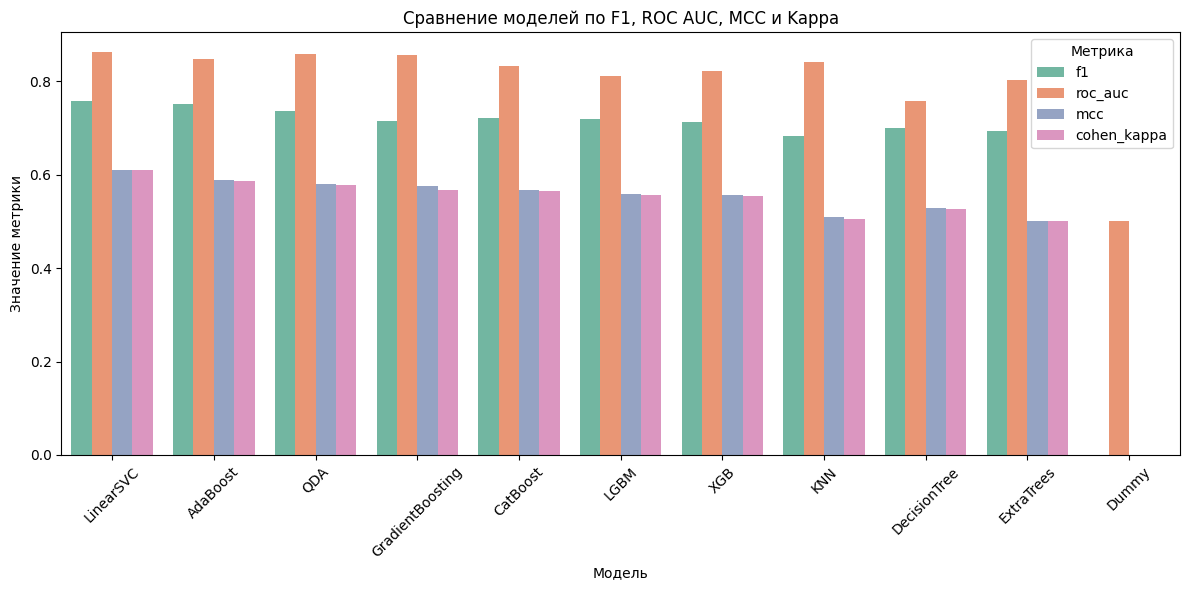

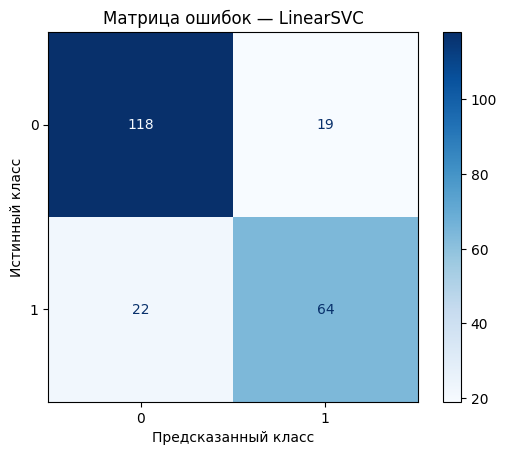

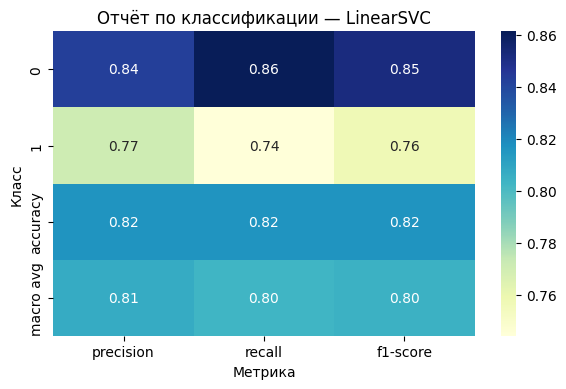

In [3]:
models = {
    "Dummy": DummyClassifier(strategy="most_frequent"),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=300, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=250, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=11),
    "QDA": QuadraticDiscriminantAnalysis(reg_param=0.1),
    "LinearSVC": LinearSVC(C=1.0, max_iter=10000, dual=False, random_state=42),
}

if HAS_CATBOOST:
    models["CatBoost"] = CatBoostClassifier(
        iterations=500, learning_rate=0.05, depth=6, loss_function="Logloss", verbose=False
    )
if HAS_LGBM:
    models["LGBM"] = LGBMClassifier(
        n_estimators=600, learning_rate=0.03, num_leaves=31, random_state=42
    )
if HAS_XGB:
    models["XGB"] = XGBClassifier(
        n_estimators=600, learning_rate=0.03, max_depth=4, subsample=0.8,
        colsample_bytree=0.8, reg_lambda=1.0, objective="binary:logistic",
        eval_metric="logloss", random_state=42
    )

results = []
fitted_pipelines = {}

for name, clf in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess_with_names), ("clf", clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]
    elif hasattr(pipe.named_steps["clf"], "decision_function"):
        y_proba = pipe.decision_function(X_test)
    else:
        y_proba = y_pred

    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "mcc": matthews_corrcoef(y_test, y_pred),
        "cohen_kappa": cohen_kappa_score(y_test, y_pred),
    }
    results.append(metrics)
    fitted_pipelines[name] = pipe

res_df = pd.DataFrame(results)
res_df["mean_score"] = res_df[["f1", "roc_auc", "mcc", "cohen_kappa"]].mean(axis=1)
res_df = res_df.sort_values(by="mean_score", ascending=False)

plt.figure(figsize=(12,6))
res_melt = res_df.melt(
    id_vars="model", 
    value_vars=["f1","roc_auc","mcc","cohen_kappa"], 
    var_name="Метрика", 
    value_name="Значение"
)
sns.barplot(data=res_melt, x="model", y="Значение", hue="Метрика", palette="Set2")
plt.title("Сравнение моделей по F1, ROC AUC, MCC и Kappa")
plt.xlabel("Модель")
plt.ylabel("Значение метрики")
plt.xticks(rotation=45)
plt.legend(title="Метрика")
plt.tight_layout()
plt.show()

best_name = res_df.iloc[0]["model"]
best_pipe = fitted_pipelines[best_name]
y_pred_best = best_pipe.predict(X_test)

ConfusionMatrixDisplay.from_estimator(best_pipe, X_test, y_test, cmap="Blues")
plt.title(f"Матрица ошибок — {best_name}")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.show()

report = classification_report(y_test, y_pred_best, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(6,4))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title(f"Отчёт по классификации — {best_name}")
plt.xlabel("Метрика")
plt.ylabel("Класс")
plt.tight_layout()
plt.show()

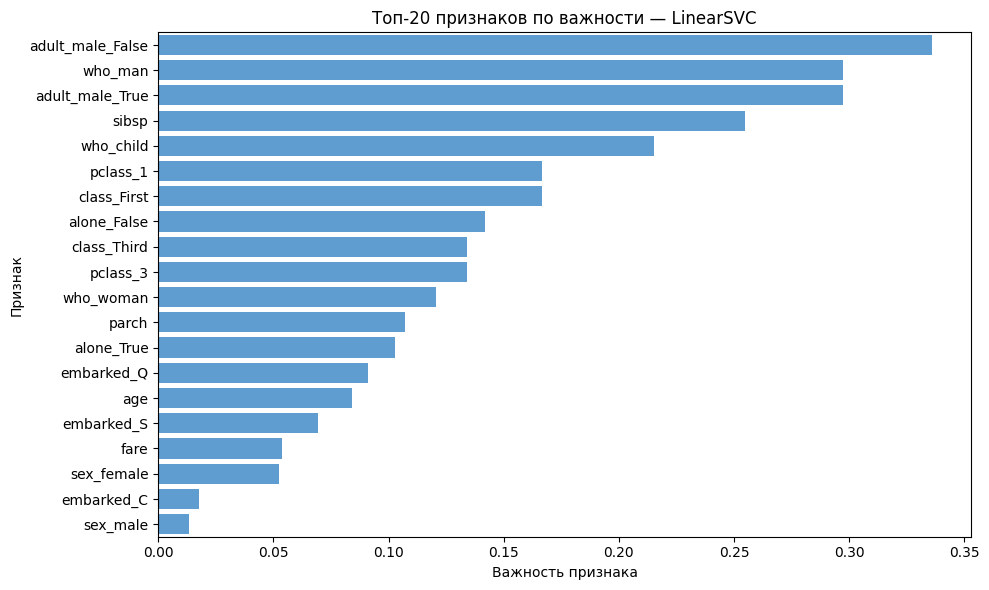

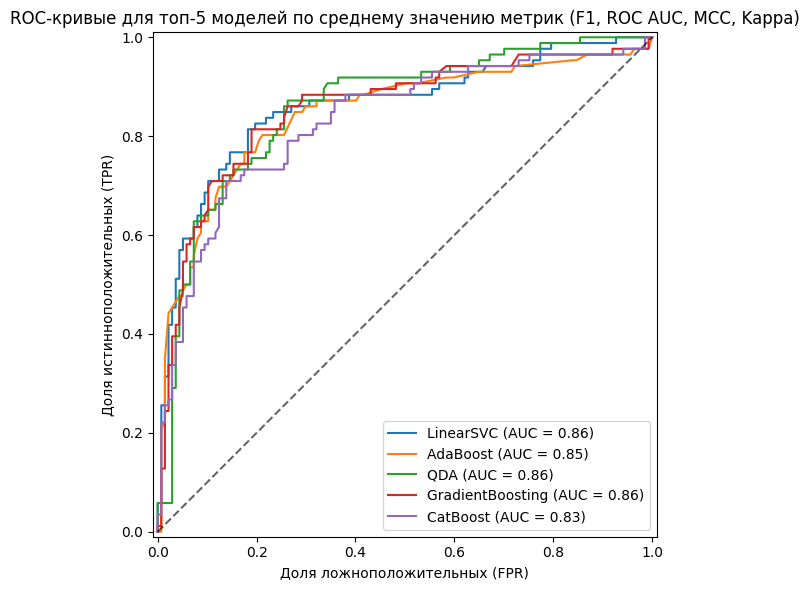

In [4]:
def get_feature_names(preprocess_with_names, X):
    ct = preprocess_with_names.named_steps["preprocess"]
    num_names = ct.named_transformers_["num"].named_steps["imputer"].get_feature_names_out(numeric_features)
    cat_encoder = ct.named_transformers_["cat"].named_steps["encoder"]
    cat_names = cat_encoder.get_feature_names_out(categorical_features)
    return np.concatenate([num_names, cat_names])

feature_names = get_feature_names(best_pipe.named_steps["preprocess"], X_train)

importances = None
clf = best_pipe.named_steps["clf"]

if hasattr(clf, "feature_importances_"):
    importances = clf.feature_importances_
elif hasattr(clf, "coef_"):
    coef = clf.coef_
    if coef.ndim > 1:
        coef = coef[0]
    importances = np.abs(coef)
elif HAS_CATBOOST and isinstance(clf, CatBoostClassifier):
    importances = clf.get_feature_importance()
else:
    r = permutation_importance(best_pipe, X_test, y_test, n_repeats=10, random_state=42, scoring="f1")
    importances = r.importances_mean
    feature_names = get_feature_names(best_pipe.named_steps["preprocess"], X_test)

imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
imp_df = imp_df.sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=imp_df.head(20), x="importance", y="feature", color="#4C9EE3")
plt.title(f"Топ-20 признаков по важности — {best_name}")
plt.xlabel("Важность признака")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()

top5 = list(res_df["model"].head(5))
fig, ax = plt.subplots(figsize=(8, 6))
for name in top5:
    pipe = fitted_pipelines[name]
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        y_score = pipe.predict_proba(X_test)[:, 1]
    elif hasattr(pipe.named_steps["clf"], "decision_function"):
        y_score = pipe.decision_function(X_test)
    else:
        y_score = pipe.predict(X_test)
    RocCurveDisplay.from_predictions(y_test, y_score, name=name, ax=ax)
ax.plot([0, 1], [0, 1], "k--", alpha=0.6)
ax.set_title("ROC-кривые для топ-5 моделей по среднему значению метрик (F1, ROC AUC, MCC, Kappa)")
ax.set_xlabel("Доля ложноположительных (FPR)")
ax.set_ylabel("Доля истинноположительных (TPR)")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show();